Plots nested sampling and vacuum fits for PBH + ET + CE analysis.

In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [289]:
from math import pi
from operator import itemgetter
import os
import pickle
from typing import Iterable, Optional, Tuple, Union

import dynesty
from dynesty import plotting as dyplot
from dynesty.plotting import _hist2d, _quantile as quantile
from dynesty import utils as dyfunc
import jax.numpy as jnp
from matplotlib import ticker, rc
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter as norm_kde
from tqdm.auto import tqdm

from pydd.analysis import calculate_match_unnormd_fft, get_match_pads, loglikelihood_fft
from pydd.binary import MSUN, DAY, WEEK, YR, PC, Phi_to_c
# from pydd.noise import S_n_et as S_n, f_range_et as f_range_n
from pydd.noise import S_n_et, S_n_ce, f_range_et, f_range_ce
from pydd.utils import get_target_pbh_dynamicdress


rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

## Setup

In [278]:
plt.style.use("../plot_style.mplstyle")
LEVELS = (0.68268, 0.95450, 0.99730)
# LEVELS = [1 - np.exp(-(x ** 2) / 2) for x in [1, 2, 3]]
TRUTH_KWARGS = dict(color="k", linewidth=0.75, linestyle="--")
T_OBS = 1 * DAY
SNR_THRESH = 12
# Noise doesn't matter
DD_D, F_RANGE_D = get_target_pbh_dynamicdress(
    1 * MSUN, 1e-3 * MSUN, T_OBS, SNR_THRESH, S_n_et, f_range_et
)


def get_HDI_thresholds(x, cred_level=LEVELS):
    """
    Taken from swyft.plot.plot
    """
    x = x.flatten()
    x = np.sort(x)[::-1]  # Sort backwards
    total_mass = x.sum()
    enclosed_mass = np.cumsum(x)
    idx = [np.argmax(enclosed_mass >= total_mass * f) for f in cred_level]
    levels = np.array(x[idx])
    return levels


def my_corner(
    results,
    axes,
    truths,
    color="grey",
    truth_kwargs: dict = TRUTH_KWARGS,
    bins_1d: Union[float, list[float]] = 50,
    smooth: Union[float, list[float]] = 0.015,
    levels: list[float] = LEVELS,
    offsets: np.ndarray = np.zeros(4),
    contour_kwargs: Optional[dict] = None,
    contourf_kwargs: Optional[dict] = None,
    no_fill_contours: Optional[bool] = False,
):
    span = [0.999999426697 for i in range(2)]

    samples = (results["samples"] - offsets).T
    ndim = samples.shape[0]
    weights = np.exp(results["logwt"] - results["logz"][-1])
    if type(bins_1d) == float:
        bins_1d = (bins_1d for _ in range(len(samples)))

    for i, x in enumerate(samples):
        ax = axes[i, i]
        ax.hist(
            x,
            weights=weights,
            bins=bins_1d[i],
            density=True,
            histtype="step",
            color=color,
        )
        ax.axvline(truths[i], **truth_kwargs)

        for j, y in enumerate(samples):
            ax = axes[i, j]
            if j == i:
                continue
            if j > i:
                ax.axis("off")
                continue
            _hist2d(
                y,
                x,
                weights=weights,
                ax=ax,
                color=color,
                smooth=smooth,
                levels=levels,
                contour_kwargs=contour_kwargs,
                contourf_kwargs=contourf_kwargs,
                no_fill_contours=no_fill_contours,
                plot_density=False,
            )
            ax.axvline(truths[j], **truth_kwargs)
            ax.axhline(truths[i], **truth_kwargs)

## Plot 2D

In [280]:
labels = (r"$\rho_6$ [$10^{16}$ M$_\odot$/pc$^3$]", r"$\Delta\mathcal{M}$ [M$_\odot$]")
quantiles_2d = [0.6827, 0.9545, 0.9973]  # more typical for Bayesian analyses
truths = (DD_D.rho_6 / (1e16 * MSUN / PC**3), 0)
offsets = (0, DD_D.M_chirp / MSUN)

with open(f"../scripts/ns/ns-et-1day-test-2d.pkl", "rb") as infile:
    results_et_1day = pickle.load(infile)

with open(f"../scripts/ns/ns-et-1week-test-2d.pkl", "rb") as infile:
    results_et_1week = pickle.load(infile)

with open(f"../scripts/ns/ns-et-1month-test-2d.pkl", "rb") as infile:
    results_et_1month = pickle.load(infile)

with open(f"../scripts/ns/ns-et-1yr-test-2d.pkl", "rb") as infile:
    results_et_1yr = pickle.load(infile)

with open(f"../scripts/ns/ns-ce-1day-test-2d.pkl", "rb") as infile:
    results_ce_1day = pickle.load(infile)

with open(f"../scripts/ns/ns-ce-1week-test-2d.pkl", "rb") as infile:
    results_ce_1week = pickle.load(infile)

with open(f"../scripts/ns/ns-ce-1month-test-2d.pkl", "rb") as infile:
    results_ce_1month = pickle.load(infile)

with open(f"../scripts/ns/ns-ce-1yr-test-2d.pkl", "rb") as infile:
    results_ce_1yr = pickle.load(infile)

### CE

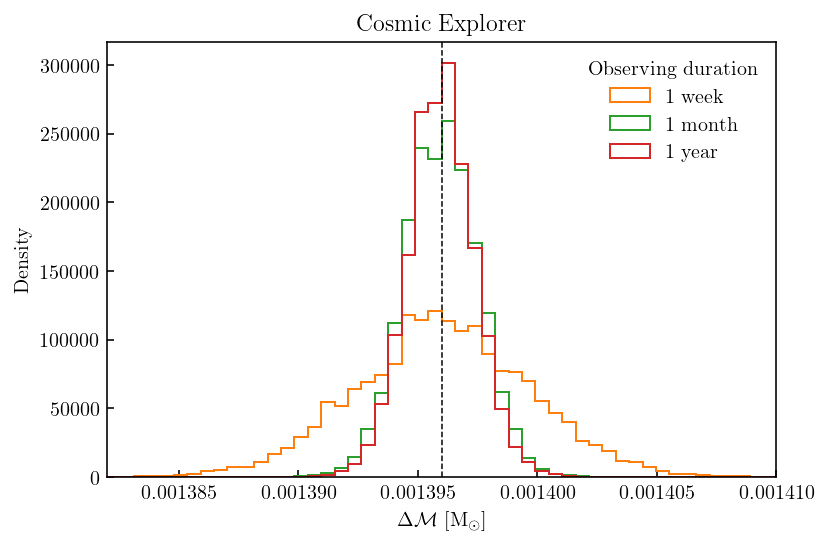

In [281]:
# plt.figure(figsize=(8, 6))

bins = np.linspace(0.001382, 0.00141, 51)
for i, (results, t_obs_label) in enumerate(
    zip(
        [results_ce_1week, results_ce_1month, results_ce_1yr],
        ["1 week", "1 month", "1 year"],
    ),
    start=1,
):
    samples = (results["samples"] - offsets).T[0]
    ndim = samples.shape[0]
    weights = np.exp(results["logwt"] - results["logz"][-1])
    plt.hist(
        samples,
        bins,
        weights=weights,
        density=True,
        color=f"C{i}",
        histtype="step",
        label=t_obs_label,
    )

plt.axvline(DD_D.rho_6 / (1e16 * MSUN / PC ** 3), **TRUTH_KWARGS)
plt.xlim(bins[[0, -1]])
plt.xlabel(labels[1])
plt.ylabel("Density")
plt.legend(title="Observing duration")
plt.title("Cosmic Explorer")
plt.savefig("../figures/post-rho6-ce-week-month-year-2d.pdf")

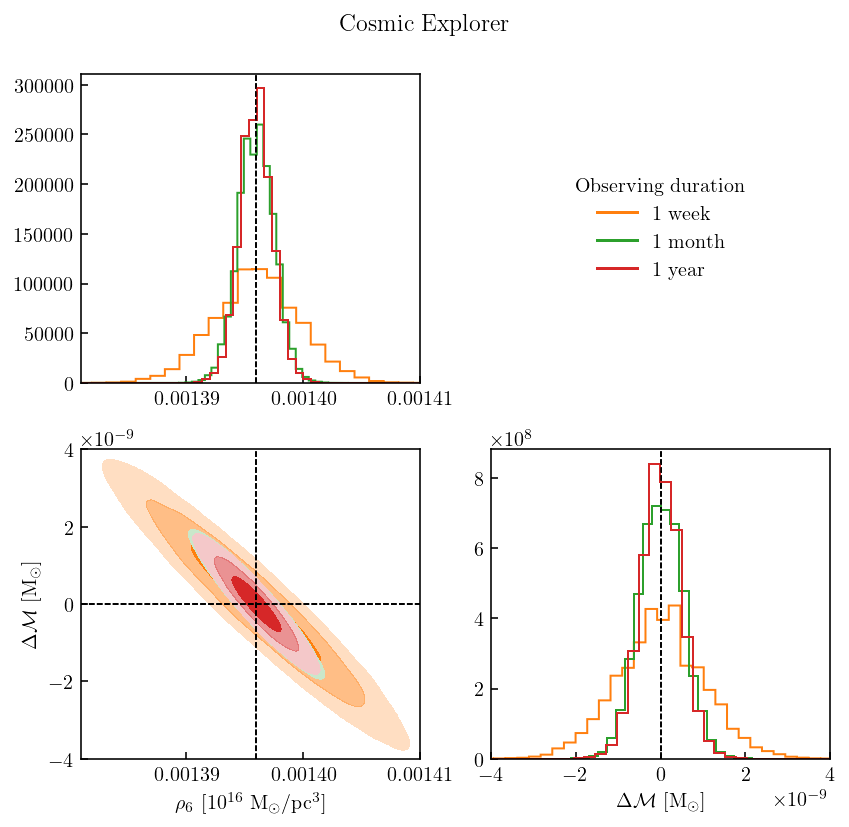

In [282]:
ndim = 2
fig, axes = plt.subplots(ndim, ndim, figsize=(3 * ndim, 3 * ndim))

offsets = (0, DD_D.M_chirp / MSUN)

my_corner(
    results_ce_1week,
    axes,
    truths,
    "C1",
    smooth=0.018,
    bins_1d=(800, 800),
    offsets=offsets,
    contour_kwargs=dict(linewidths=0),
)
my_corner(
    results_ce_1month,
    axes,
    truths,
    "C2",
    smooth=0.018,
    bins_1d=(600, 300),
    offsets=offsets,
    contour_kwargs=dict(linewidths=0),
)
my_corner(
    results_ce_1yr,
    axes,
    truths,
    "C3",
    smooth=0.018,
    bins_1d=(500, 250),
    offsets=offsets,
    contour_kwargs=dict(linewidths=0),
)

for i, ax in enumerate(axes[-1, :]):
    ax.set_xlabel(labels[i])

for j, ax in enumerate(axes[1:, 0], 1):
    ax.set_ylabel(labels[j])

# Week/month/year
ranges = [
    (0.001381, 0.00141),
    (-4e-9, 4e-9),
]
for i in range(ndim):
    for j in range(i, ndim):
        axes[j, i].set_xlim(ranges[i])

for i in range(1, ndim):
    for j in range(0, i):
        axes[i, j].set_ylim(ranges[i])

ax = axes[0, 1]
handles = ax.get_legend_handles_labels()[0]
for i, t_obs_label in enumerate(["1 week", "1 month", "1 year"], 1):
    line = Line2D([0], [0], label=t_obs_label, color=f"C{i}")
    handles.extend([line])
ax.legend(handles=handles, title="Observing duration", loc="center")

fig.suptitle("Cosmic Explorer")
fig.tight_layout(rect=[0, 0.03, 1, 0.985])
fig.savefig("../figures/post-ce-week-month-year-2d.pdf")

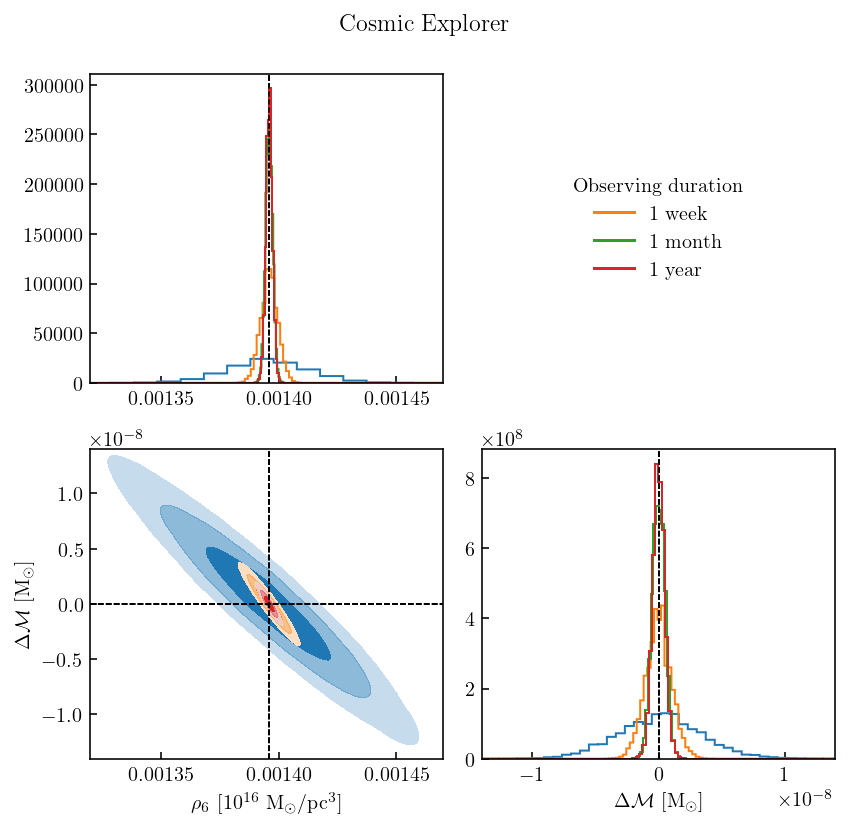

In [283]:
ndim = 2
fig, axes = plt.subplots(ndim, ndim, figsize=(3 * ndim, 3 * ndim))

offsets = (0, DD_D.M_chirp / MSUN)

my_corner(
    results_ce_1day,
    axes,
    truths,
    "C0",
    smooth=0.018,
    bins_1d=(800, 800),
    offsets=offsets,
    contour_kwargs=dict(linewidths=0),
)
my_corner(
    results_ce_1week,
    axes,
    truths,
    "C1",
    smooth=0.018,
    bins_1d=(800, 800),
    offsets=offsets,
    contour_kwargs=dict(linewidths=0),
)
my_corner(
    results_ce_1month,
    axes,
    truths,
    "C2",
    smooth=0.018,
    bins_1d=(600, 300),
    offsets=offsets,
    contour_kwargs=dict(linewidths=0),
)
my_corner(
    results_ce_1yr,
    axes,
    truths,
    "C3",
    smooth=0.018,
    bins_1d=(500, 250),
    offsets=offsets,
    contour_kwargs=dict(linewidths=0),
)

for i, ax in enumerate(axes[-1, :]):
    ax.set_xlabel(labels[i])

for j, ax in enumerate(axes[1:, 0], 1):
    ax.set_ylabel(labels[j])

# Week/month/year
ranges = [
    (0.00132, 0.00147),
    (-1.4e-8, 1.4e-8),
]
for i in range(ndim):
    for j in range(i, ndim):
        axes[j, i].set_xlim(ranges[i])

for i in range(1, ndim):
    for j in range(0, i):
        axes[i, j].set_ylim(ranges[i])

ax = axes[0, 1]
handles = ax.get_legend_handles_labels()[0]
for i, t_obs_label in enumerate(["1 week", "1 month", "1 year"], 1):
    line = Line2D([0], [0], label=t_obs_label, color=f"C{i}")
    handles.extend([line])
ax.legend(handles=handles, title="Observing duration", loc="center")

fig.suptitle("Cosmic Explorer")
fig.tight_layout(rect=[0, 0.03, 1, 0.985])
fig.savefig("../figures/post-ce-all-2d.pdf")

### ET

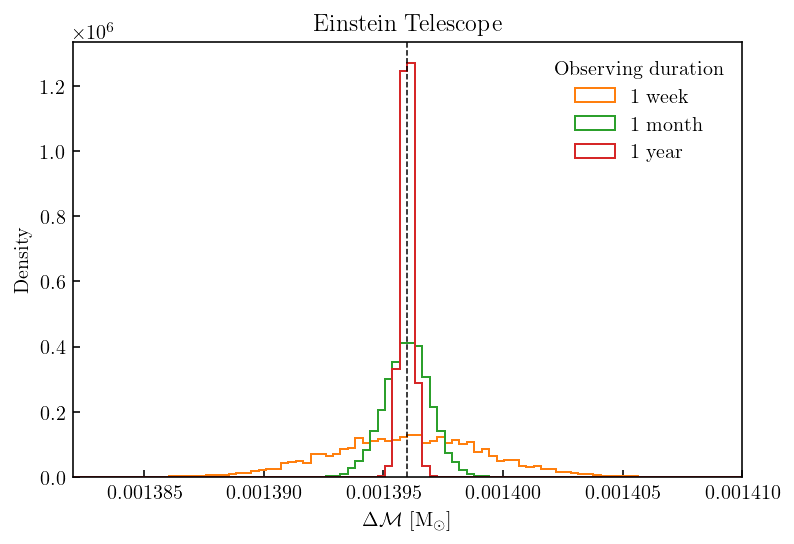

In [284]:
# plt.figure(figsize=(8, 6))

bins = np.linspace(0.001382, 0.00141, 91)
for i, (results, t_obs_label) in enumerate(
    zip(
        [results_et_1week, results_et_1month, results_et_1yr],
        ["1 week", "1 month", "1 year"],
    ),
    start=1,
):
    samples = (results["samples"] - offsets).T[0]
    ndim = samples.shape[0]
    weights = np.exp(results["logwt"] - results["logz"][-1])
    plt.hist(
        samples,
        bins,
        weights=weights,
        density=True,
        color=f"C{i}",
        histtype="step",
        label=t_obs_label,
    )

plt.axvline(DD_D.rho_6 / (1e16 * MSUN / PC ** 3), **TRUTH_KWARGS)
plt.xlim(bins[[0, -1]])
plt.xlabel(labels[1])
plt.ylabel("Density")
plt.legend(title="Observing duration")
plt.title("Einstein Telescope")
plt.savefig("../figures/post-rho6-et-week-month-year-2d.pdf")

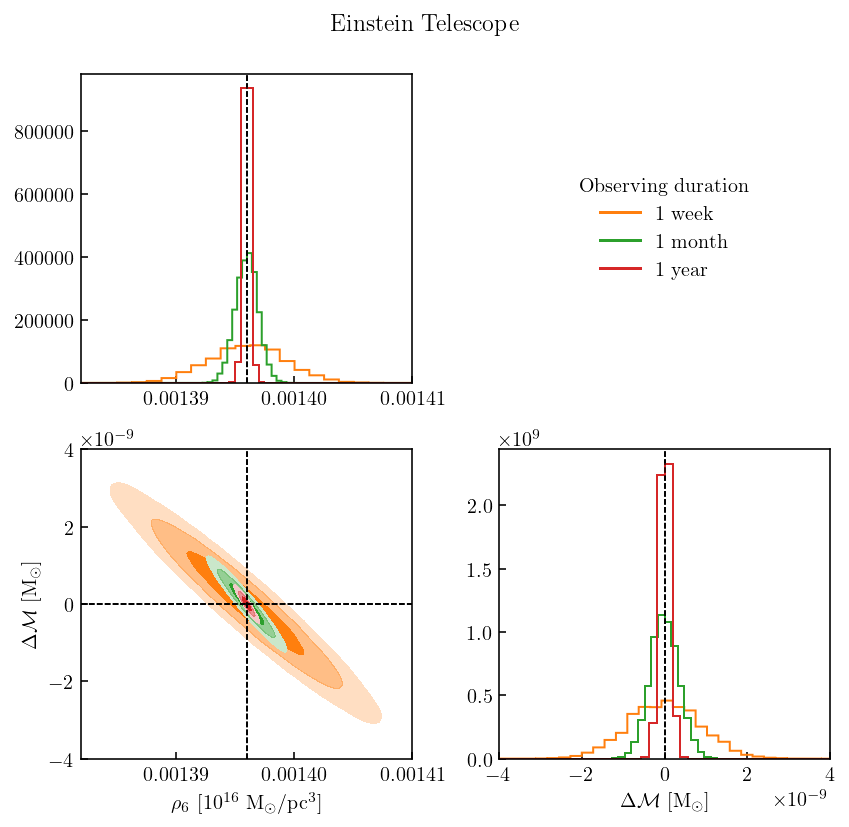

In [285]:
ndim = 2
fig, axes = plt.subplots(ndim, ndim, figsize=(3 * ndim, 3 * ndim))

offsets = (0, DD_D.M_chirp / MSUN)

# my_corner(
#     results_et_1day,
#     axes,
#     truths,
#     "C0",
#     smooth=0.018,
#     bins_1d=(800, 800),
#     offsets=offsets,
#     contour_kwargs=dict(linewidths=0),
# )
my_corner(
    results_et_1week,
    axes,
    truths,
    "C1",
    smooth=0.018,
    bins_1d=(800, 800),
    offsets=offsets,
    contour_kwargs=dict(linewidths=0),
)
my_corner(
    results_et_1month,
    axes,
    truths,
    "C2",
    smooth=0.018,
    bins_1d=(600, 300),
    offsets=offsets,
    contour_kwargs=dict(linewidths=0),
)
my_corner(
    results_et_1yr,
    axes,
    truths,
    "C3",
    smooth=0.018,
    bins_1d=(500, 250),
    offsets=offsets,
    contour_kwargs=dict(linewidths=0),
)

for i, ax in enumerate(axes[-1, :]):
    ax.set_xlabel(labels[i])

for j, ax in enumerate(axes[1:, 0], 1):
    ax.set_ylabel(labels[j])

# Week/month/year
ranges = [
    (0.001382, 0.00141),
    (-4e-9, 4e-9),
]
for i in range(ndim):
    for j in range(i, ndim):
        axes[j, i].set_xlim(ranges[i])

for i in range(1, ndim):
    for j in range(0, i):
        axes[i, j].set_ylim(ranges[i])

ax = axes[0, 1]
handles = ax.get_legend_handles_labels()[0]
for i, t_obs_label in enumerate(["1 week", "1 month", "1 year"], 1):
    line = Line2D([0], [0], label=t_obs_label, color=f"C{i}")
    handles.extend([line])
ax.legend(handles=handles, title="Observing duration", loc="center")

fig.suptitle("Einstein Telescope")
fig.tight_layout(rect=[0, 0.03, 1, 0.985])
fig.savefig("../figures/post-et-week-month-year-2d.pdf")

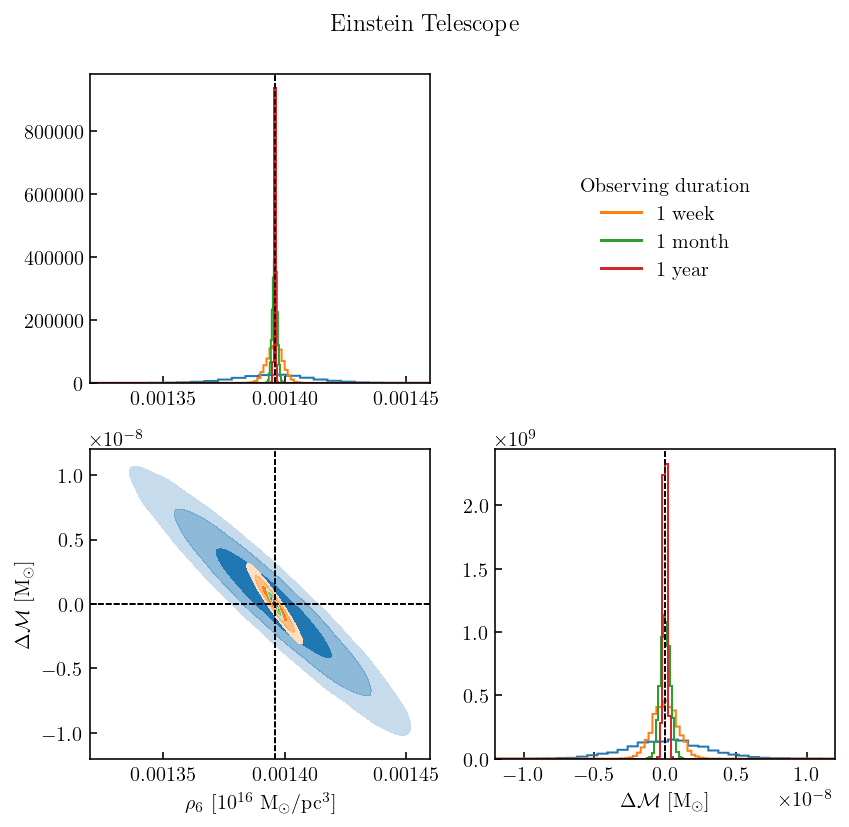

In [286]:
ndim = 2
fig, axes = plt.subplots(ndim, ndim, figsize=(3 * ndim, 3 * ndim))

offsets = (0, DD_D.M_chirp / MSUN)

my_corner(
    results_et_1day,
    axes,
    truths,
    "C0",
    smooth=0.018,
    bins_1d=(800, 800),
    offsets=offsets,
    contour_kwargs=dict(linewidths=0),
)
my_corner(
    results_et_1week,
    axes,
    truths,
    "C1",
    smooth=0.018,
    bins_1d=(800, 800),
    offsets=offsets,
    contour_kwargs=dict(linewidths=0),
)
my_corner(
    results_et_1month,
    axes,
    truths,
    "C2",
    smooth=0.018,
    bins_1d=(600, 300),
    offsets=offsets,
    contour_kwargs=dict(linewidths=0),
)
my_corner(
    results_et_1yr,
    axes,
    truths,
    "C3",
    smooth=0.018,
    bins_1d=(500, 250),
    offsets=offsets,
    contour_kwargs=dict(linewidths=0),
)

for i, ax in enumerate(axes[-1, :]):
    ax.set_xlabel(labels[i])

for j, ax in enumerate(axes[1:, 0], 1):
    ax.set_ylabel(labels[j])

# Week/month/year
ranges = [
    (0.00132, 0.00146),
    (-1.2e-8, 1.2e-8),
]
for i in range(ndim):
    for j in range(i, ndim):
        axes[j, i].set_xlim(ranges[i])

for i in range(1, ndim):
    for j in range(0, i):
        axes[i, j].set_ylim(ranges[i])

ax = axes[0, 1]
handles = ax.get_legend_handles_labels()[0]
for i, t_obs_label in enumerate(["1 week", "1 month", "1 year"], 1):
    line = Line2D([0], [0], label=t_obs_label, color=f"C{i}")
    handles.extend([line])
ax.legend(handles=handles, title="Observing duration", loc="center")

fig.suptitle("Einstein Telescope")
fig.tight_layout(rect=[0, 0.03, 1, 0.985])
fig.savefig("../figures/post-et-all-2d.pdf")

## Plot 4D

### Load

In [287]:
labels = (
    r"$\gamma_s$",
    r"$\rho_6$ [$10^{16}$ M$_\odot$/pc$^3$]",
    r"$\Delta\mathcal{M}$ [M$_\odot$]",
    r"$\log_{10} q$",
)
quantiles_2d = [0.6827, 0.9545, 0.9973]  # more typical for Bayesian analyses
offsets = (0, 0, DD_D.M_chirp / MSUN, 0)

with open(f"../scripts/ns/ns-et-1day-test-4d.pkl", "rb") as infile:
    results_et_1day = pickle.load(infile)

with open(f"../scripts/ns/ns-et-1week-test-4d.pkl", "rb") as infile:
    results_et_1week = pickle.load(infile)

with open(f"../scripts/ns/ns-et-1month-test-4d.pkl", "rb") as infile:
    results_et_1month = pickle.load(infile)

with open(f"../scripts/ns/ns-et-1yr-test-4d.pkl", "rb") as infile:
    results_et_1yr = pickle.load(infile)

with open(f"../scripts/ns/ns-ce-1day-test-4d.pkl", "rb") as infile:
    results_ce_1day = pickle.load(infile)

with open(f"../scripts/ns/ns-ce-1week-test-4d.pkl", "rb") as infile:
    results_ce_1week = pickle.load(infile)

with open(f"../scripts/ns/ns-ce-1month-test-4d.pkl", "rb") as infile:
    results_ce_1month = pickle.load(infile)

with open(f"../scripts/ns/ns-ce-1yr-test-4d.pkl", "rb") as infile:
    results_ce_1yr = pickle.load(infile)

Measurement errors

In [290]:
for telescope, res in zip(["et", "ce"], [results_et_1week, results_ce_1week]):
    print(f"{telescope}, 1 week")
    weights = np.exp(res['logwt'] - res['logz'][-1])
    for i, par in enumerate(["gamma_s", "rho_6T", "Delta M_c", "log10(q)"]):
        q_low, med, q_high = quantile(res["samples"][:, i], [0.5 - 0.34, 0.5, 0.5 + 0.34], weights)
        delta_low = med - q_low
        delta_high = q_high - med
#         print(q_low, med, q_high)
        print(f"  {par} = {med:.7g} (-{delta_low:.2g}) (+{delta_high:.2g})")
    print()

et, 1 week
  gamma_s = 2.221064 (-0.053) (+0.065)
  rho_6T = 0.001700562 (-0.00057) (+0.00088)
  Delta M_c = 0.01584577 (-2.6e-08) (+2.7e-08)
  log10(q) = -3.08575 (-0.32) (+0.36)

ce, 1 week
  gamma_s = 2.19619 (-0.06) (+0.072)
  rho_6T = 0.002031154 (-0.00082) (+0.0015)
  Delta M_c = 0.01584578 (-2.9e-08) (+2.8e-08)
  log10(q) = -3.169633 (-0.32) (+0.43)



In [291]:
for telescope, res in zip(["et", "ce"], [results_et_1yr, results_ce_1yr]):
    print(f"{telescope}, 1 yr")
    weights = np.exp(res['logwt'] - res['logz'][-1])
    for i, par in enumerate(["gamma_s", "rho_6T", "Delta M_c", "log10(q)"]):
        q_low, med, q_high = quantile(res["samples"][:, i], [0.5 - 0.34, 0.5, 0.5 + 0.34], weights)
        delta_low = med - q_low
        delta_high = q_high - med
#         print(q_low, med, q_high)
        print(f"  {par} = {med:.7g} (-{delta_low:.2g}) (+{delta_high:.2g})")
    print()

et, 1 yr
  gamma_s = 2.252885 (-0.013) (+0.012)
  rho_6T = 0.00143099 (-5.8e-05) (+0.00011)
  Delta M_c = 0.01584576 (-7.4e-09) (+8.1e-09)
  log10(q) = -2.959393 (-0.14) (+0.2)

ce, 1 yr
  gamma_s = 2.218768 (-0.06) (+0.055)
  rho_6T = 0.001707482 (-0.00038) (+0.00047)
  Delta M_c = 0.01584578 (-2.6e-08) (+3.3e-08)
  log10(q) = -3.165312 (-0.34) (+0.42)



### Bayes factor

In [292]:
print("et")
with open(f"../scripts/ns/ns-m1=10.0-m2=0.01-et-1week-test-4d.pkl", "rb") as infile:
    results_et_1week_bf = pickle.load(infile)

with open(f"../scripts/ns/ns-m1=10.0-m2=0.01-et-1week-test-v.pkl", "rb") as infile:
    results_et_1week_v_bf = pickle.load(infile)

dMc_fact = (1.25e-6 + 3e-6) / (2e-6 + 1e-6) * 0.04 / 0.2
jnp.exp(results_et_1week_bf["logz"][-1] - results_et_1week_v_bf["logz"][-1]) * dMc_fact

et


DeviceArray(2.03868533e+19, dtype=float64)

In [293]:
print("ce")
with open(f"../scripts/ns/ns-m1=10.0-m2=0.01-ce-1week-test-4d.pkl", "rb") as infile:
    results_ce_1week_bf = pickle.load(infile)

with open(f"../scripts/ns/ns-m1=10.0-m2=0.01-ce-1week-test-v.pkl", "rb") as infile:
    results_ce_1week_v_bf = pickle.load(infile)

dMc_fact = (4e-6 + 2e-6) / (2e-6 + 1e-6) * 0.15 / 0.2
jnp.exp(results_ce_1week_bf["logz"][-1] - results_ce_1week_v_bf["logz"][-1]) * dMc_fact

ce


DeviceArray(6085809.9814444, dtype=float64)

### Comparing 1D marginals

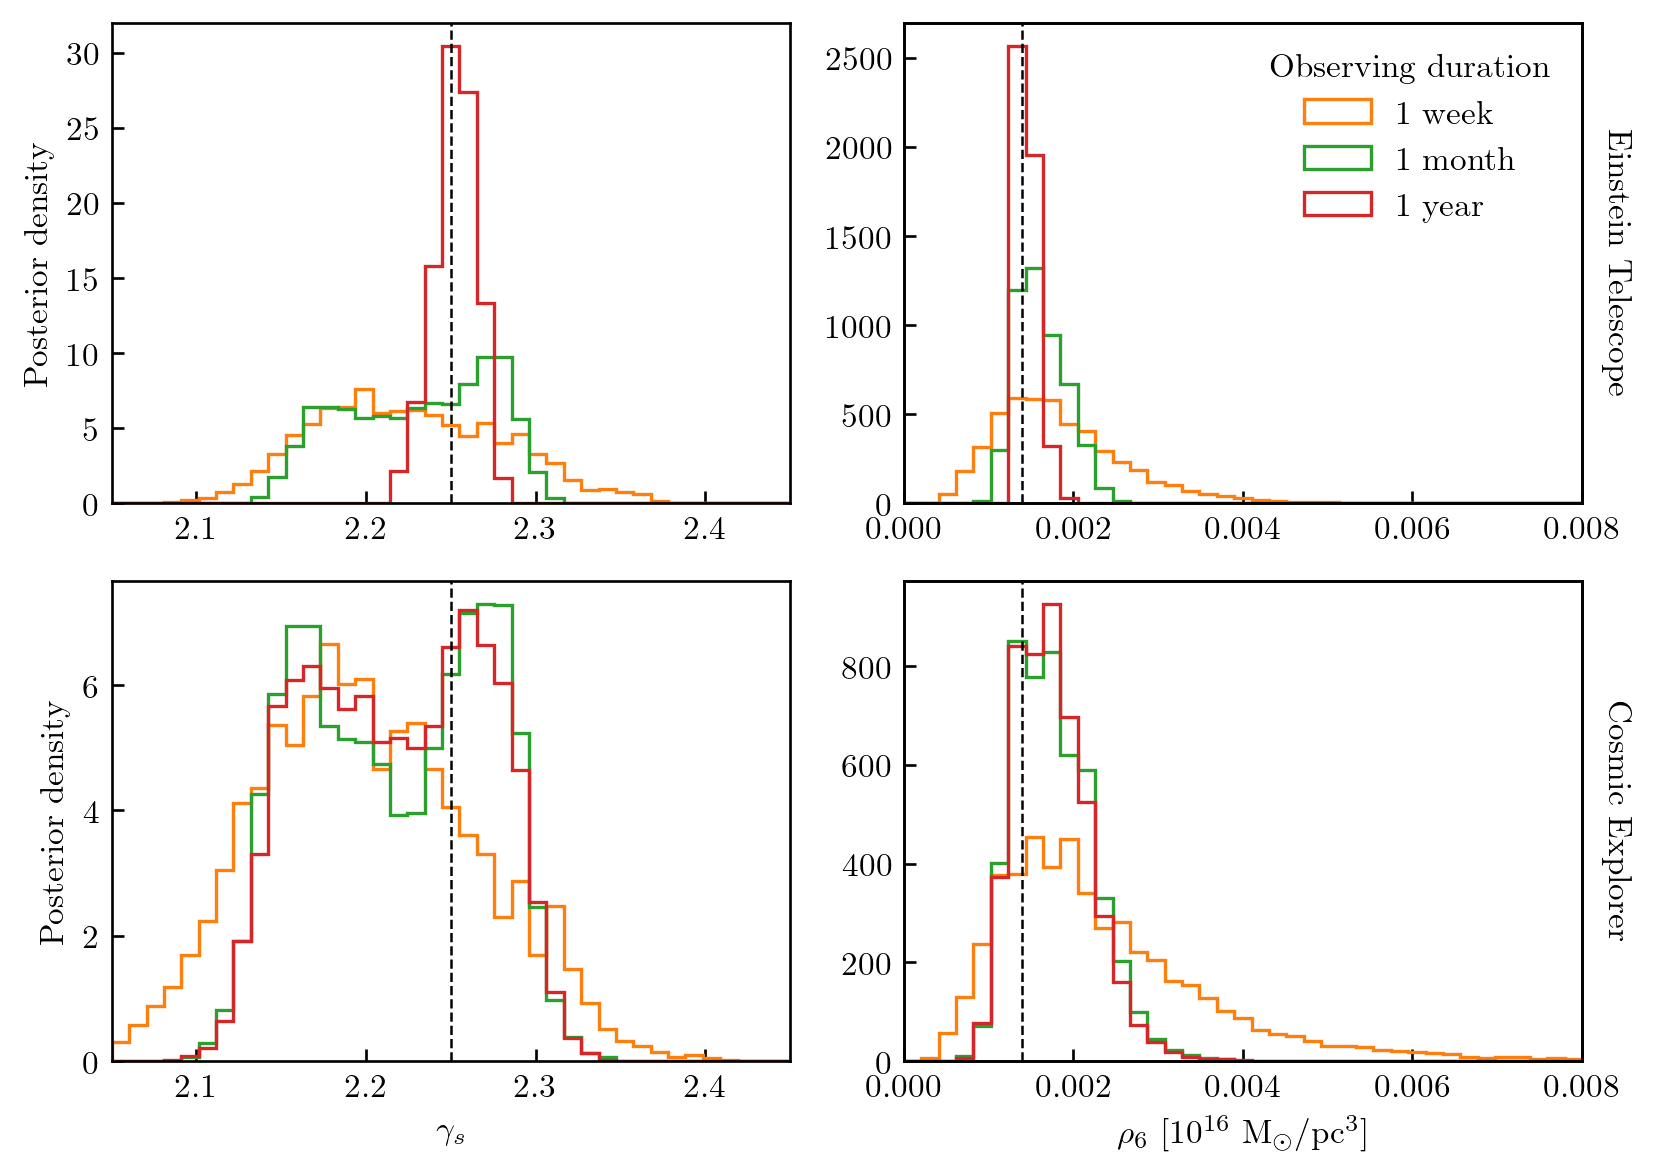

In [294]:
results_et = [results_et_1week, results_et_1month, results_et_1yr]
results_ce = [results_ce_1week, results_ce_1month, results_ce_1yr]
t_obs_labels = ["1 week", "1 month", "1 year"]
bin_list = [np.linspace(2.05, 2.45, 40), np.linspace(0., 0.008, 40)]
truths = [DD_D.gamma_s, DD_D.rho_6 / (1e16 * MSUN / PC**3)]

fig, axes = plt.subplots(2, 2, figsize=(7, 5), dpi=120)

# Column 1: rho_6
# Column 2: gamma_s
for j in range(2):  # column loop
    bins = bin_list[j]
    axs = axes.T[j]
    for results_list, ax in zip([results_et, results_ce], axs):  # row loop
        for i in range(3):  # t_obs loop
            results = results_list[i]
            t_obs_label = t_obs_labels[i]
            
            samples = (results["samples"] - offsets).T[j]
            weights = np.exp(results["logwt"] - results["logz"][-1])
            ax.hist(
                samples,
                bins,
                weights=weights,
                density=True,
                color=f"C{i + 1}",
                histtype="step",
                label=t_obs_label,
            )
        
        ax.axvline(truths[j], **TRUTH_KWARGS)
        ax.set_xlim(bins[0], bins[-1])
    ax.set_xlabel(labels[j])

for ax in axes[:, 0]:
    ax.set_ylabel("Posterior density")

for ax, telescope in zip(axes[:, 1], ["Einstein Telescope", "Cosmic Explorer"]):
    ax_right = ax.twinx()
    ax_right.set_ylabel(telescope, labelpad=15, rotation=-90)
    ax_right.set_yticks([])

axes[0, 1].legend(title="Observing duration")

fig.tight_layout()
fig.savefig("../figures/post-rho6-gamma_s-et-ce.pdf")

### CE

In [298]:
truths = (
    DD_D.gamma_s,
    DD_D.rho_6 / (1e16 * MSUN / PC ** 3),
    0,  # DD_D.M_chirp / MSUN,
    jnp.log10(DD_D.q),
)

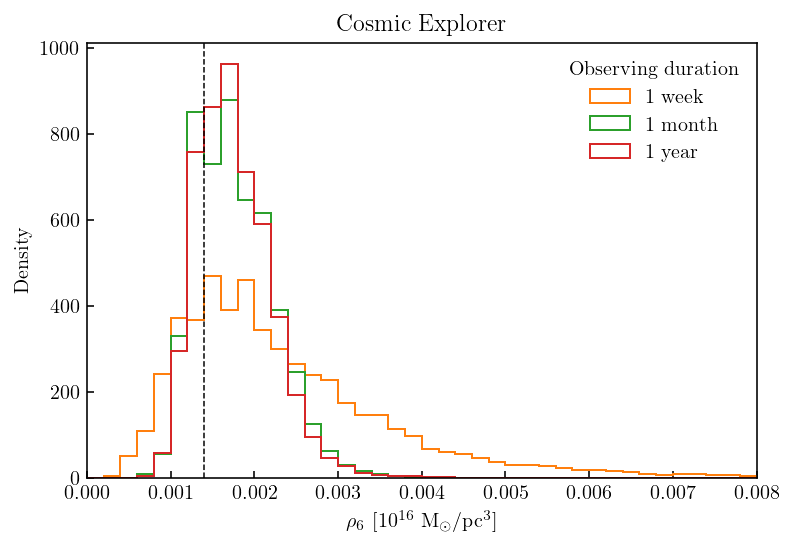

In [299]:
bins = np.linspace(0, 0.008, 41)
for i, (results, t_obs_label) in enumerate(
    zip(
        [results_ce_1week, results_ce_1month, results_ce_1yr],
        ["1 week", "1 month", "1 year"],
    ),
    start=1,
):
    samples = (results["samples"] - offsets).T[1]
    ndim = samples.shape[0]
    weights = np.exp(results["logwt"] - results["logz"][-1])
    plt.hist(
        samples,
        bins,
        weights=weights,
        density=True,
        color=f"C{i}",
        histtype="step",
        label=t_obs_label,
    )

plt.axvline(DD_D.rho_6 / (1e16 * MSUN / PC ** 3), **TRUTH_KWARGS)
plt.xlim(bins[[0, -1]])
plt.xlabel(labels[1])
plt.ylabel("Density")
plt.legend(title="Observing duration")
plt.title("Cosmic Explorer")
plt.savefig("../figures/post-rho6-ce-week-month-year-4d.pdf")

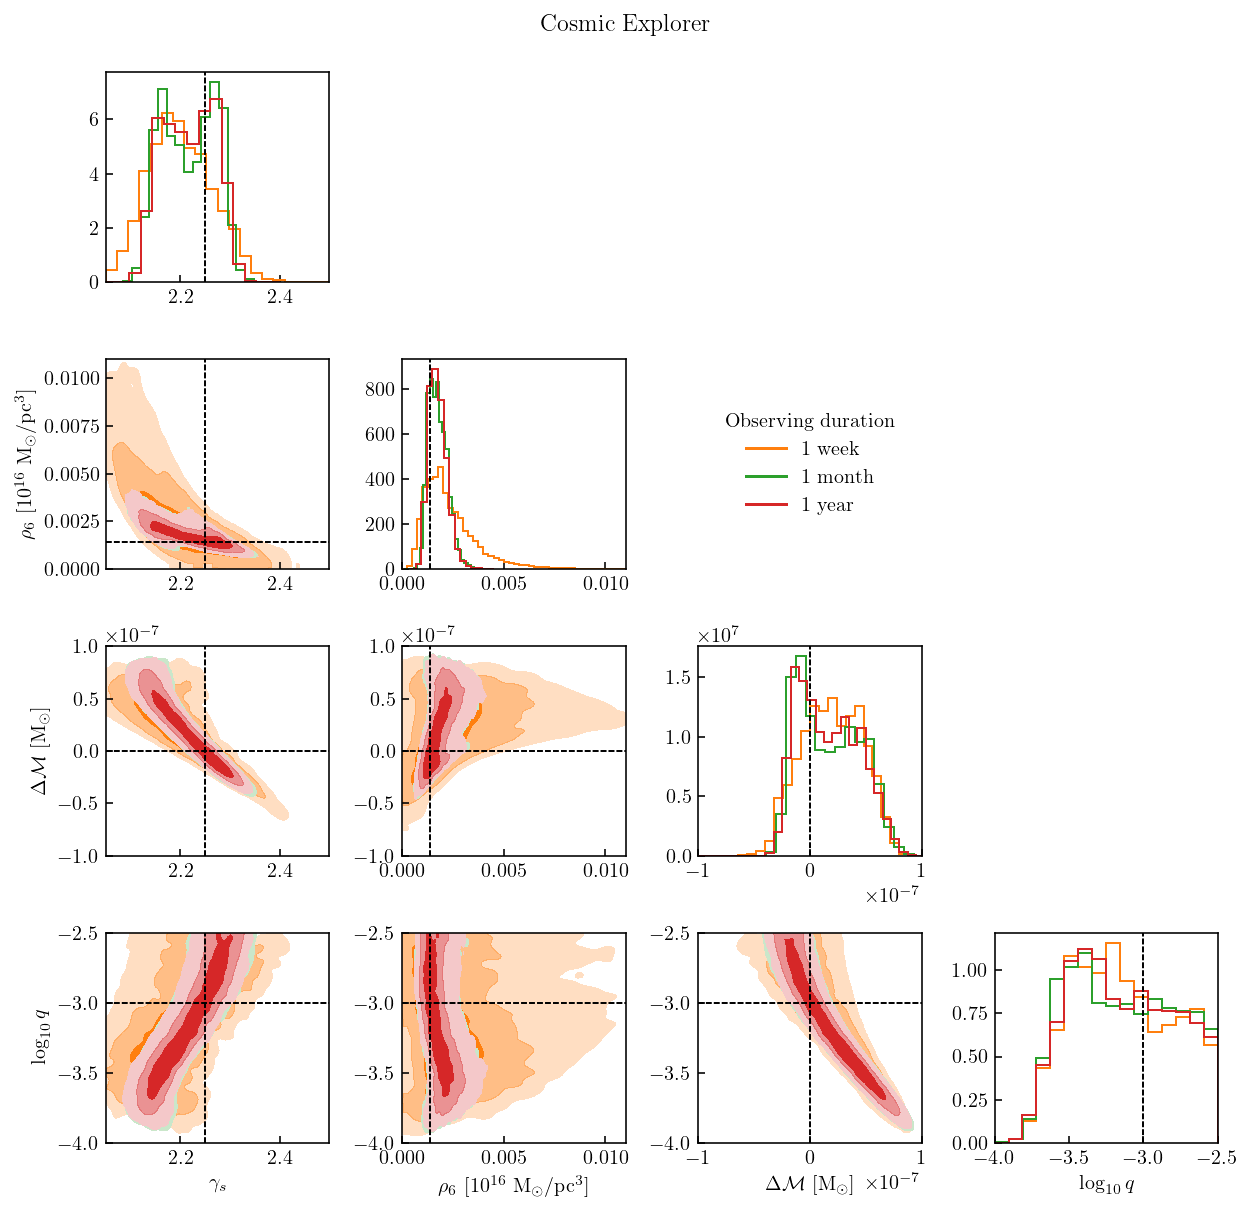

In [300]:
ndim = 4
fig, axes = plt.subplots(ndim, ndim, figsize=(2.2 * ndim, 2.2 * ndim))

offsets = (0, 0, DD_D.M_chirp / MSUN, 0)

my_corner(
    results_ce_1week,
    axes,
    truths,
    "C1",
    smooth=0.018,
    bins_1d=(20, 80, 250, 16),
    offsets=offsets,
    contour_kwargs=dict(linewidths=0),
)
my_corner(
    results_ce_1month,
    axes,
    truths,
    "C2",
    smooth=0.018,
    bins_1d=(20, 25, 250, 16),
    offsets=offsets,
    contour_kwargs=dict(linewidths=0),
)
my_corner(
    results_ce_1yr,
    axes,
    truths,
    "C3",
    smooth=0.018,
    bins_1d=(15, 15, 40, 16),
    offsets=offsets,
    contour_kwargs=dict(linewidths=0),
)

for i, ax in enumerate(axes[-1, :]):
    ax.set_xlabel(labels[i])

for j, ax in enumerate(axes[1:, 0], 1):
    ax.set_ylabel(labels[j])

# Week/month/year
ranges = [
    (2.05, 2.5),
    (0.0, 0.011),
    (-1e-7, 1e-7),
    (-4, -2.5),
]
for i in range(ndim):
    for j in range(i, ndim):
        axes[j, i].set_xlim(ranges[i])

for i in range(1, ndim):
    for j in range(0, i):
        axes[i, j].set_ylim(ranges[i])

ax = axes[1, 2]
handles = ax.get_legend_handles_labels()[0]
for i, t_obs_label in enumerate(["1 week", "1 month", "1 year"], 1):
    line = Line2D([0], [0], label=t_obs_label, color=f"C{i}")
    handles.extend([line])
ax.legend(handles=handles, title="Observing duration", loc="center")

fig.suptitle("Cosmic Explorer")
fig.tight_layout(rect=[0, 0.03, 1, 0.985])
fig.savefig("../figures/post-ce-week-month-year-4d.pdf")

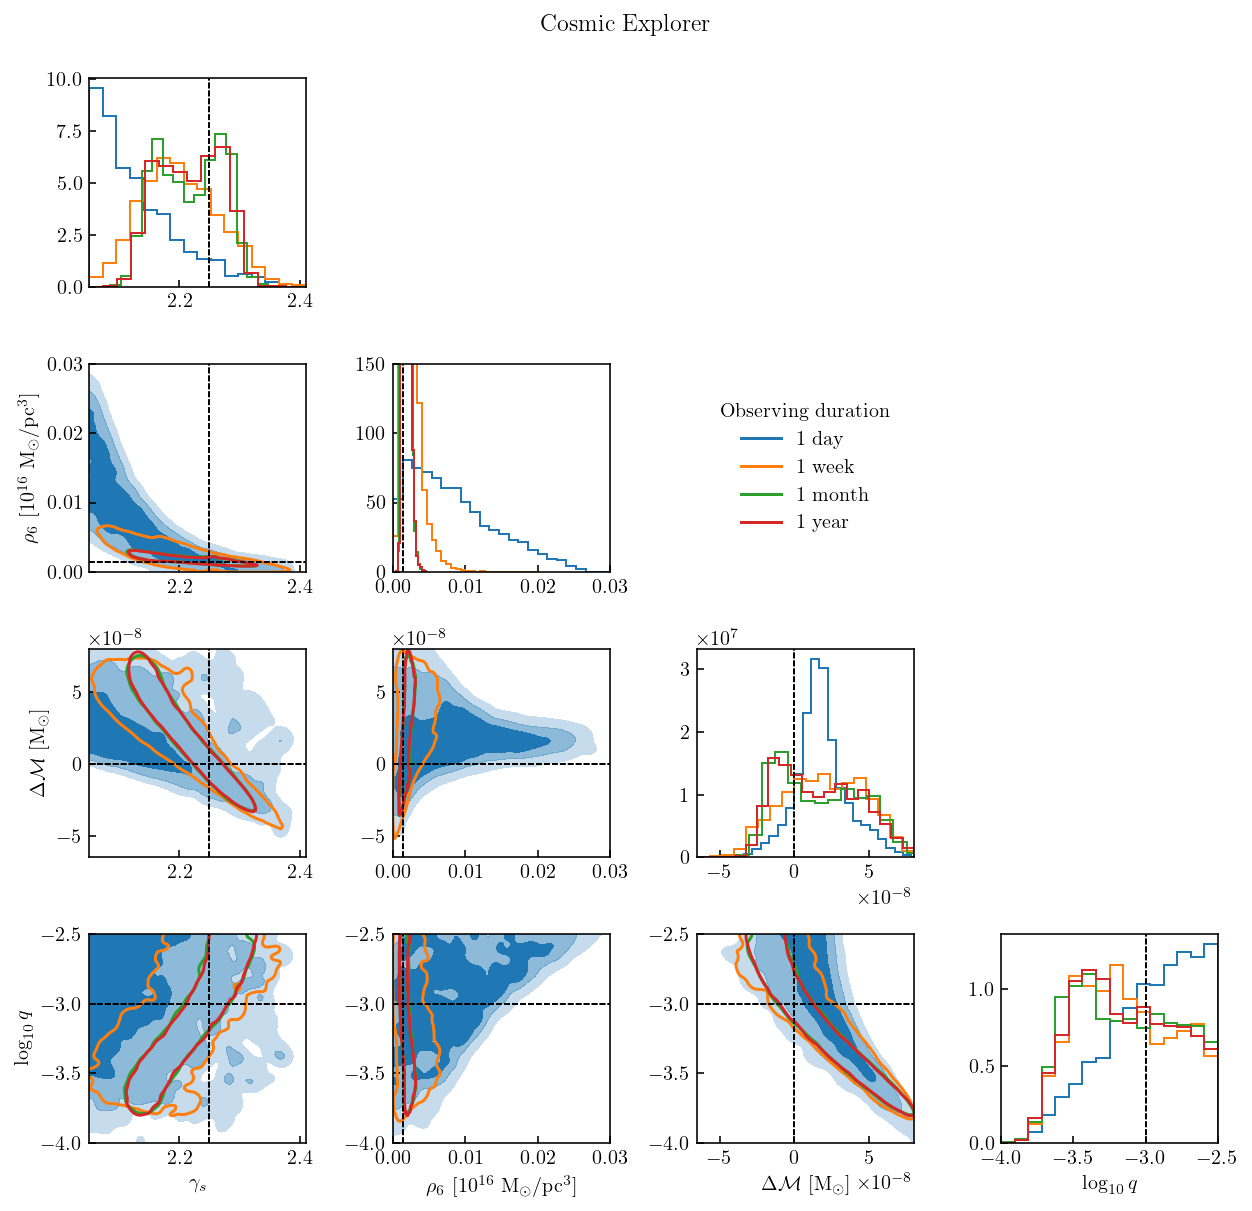

In [301]:
ndim = 4
fig, axes = plt.subplots(ndim, ndim, figsize=(2.2 * ndim, 2.2 * ndim))

offsets = (0, 0, DD_D.M_chirp / MSUN, 0)

my_corner(
    results_ce_1day,
    axes,
    truths,
    "C0",
    smooth=0.025,
    bins_1d=(20, 30, 250, 16),
    offsets=offsets,
    contour_kwargs=dict(linewidths=0)
)
my_corner(
    results_ce_1week,
    axes,
    truths,
    "C1",
    smooth=0.018,
    bins_1d=(20, 30, 250, 16),
    offsets=offsets,
    levels=(0, LEVELS[1]),
    no_fill_contours=True,
    contourf_kwargs=dict(alpha=0)
)
my_corner(
    results_ce_1month,
    axes,
    truths,
    "C2",
    smooth=0.018,
    bins_1d=(20, 15, 250, 16),
    offsets=offsets,
    levels=(0, LEVELS[1]),
    no_fill_contours=True,
    contourf_kwargs=dict(alpha=0)
)
my_corner(
    results_ce_1yr,
    axes,
    truths,
    "C3",
    smooth=0.018,
    bins_1d=(15, 15, 40, 16),
    offsets=offsets,
    levels=(0, LEVELS[1]),
    no_fill_contours=True,
    contourf_kwargs=dict(alpha=0)
)

for i, ax in enumerate(axes[-1, :]):
    ax.set_xlabel(labels[i])

for j, ax in enumerate(axes[1:, 0], 1):
    ax.set_ylabel(labels[j])

# Week/month/year
ranges = [
    (2.05, 2.41),
    (0.0, 0.03),
    (-6.5e-8, 8e-8),
    (-4, -2.5),
]
for i in range(ndim):
    for j in range(i, ndim):
        axes[j, i].set_xlim(ranges[i])

for i in range(1, ndim):
    for j in range(0, i):
        axes[i, j].set_ylim(ranges[i])

axes[1, 1].set_ylim(0, 150)

ax = axes[1, 2]
handles = ax.get_legend_handles_labels()[0]
for i, t_obs_label in enumerate(["1 day", "1 week", "1 month", "1 year"]):
    line = Line2D([0], [0], label=t_obs_label, color=f"C{i}")
    handles.extend([line])
ax.legend(handles=handles, title="Observing duration", loc="center")

fig.suptitle("Cosmic Explorer")
fig.tight_layout(rect=[0, 0.03, 1, 0.985])
fig.savefig("../figures/post-ce-all-4d.pdf")

### ET

In [302]:
truths = (
    DD_D.gamma_s,
    DD_D.rho_6 / (1e16 * MSUN / PC ** 3),
    0,  # DD_D.M_chirp / MSUN,
    jnp.log10(DD_D.q),
)

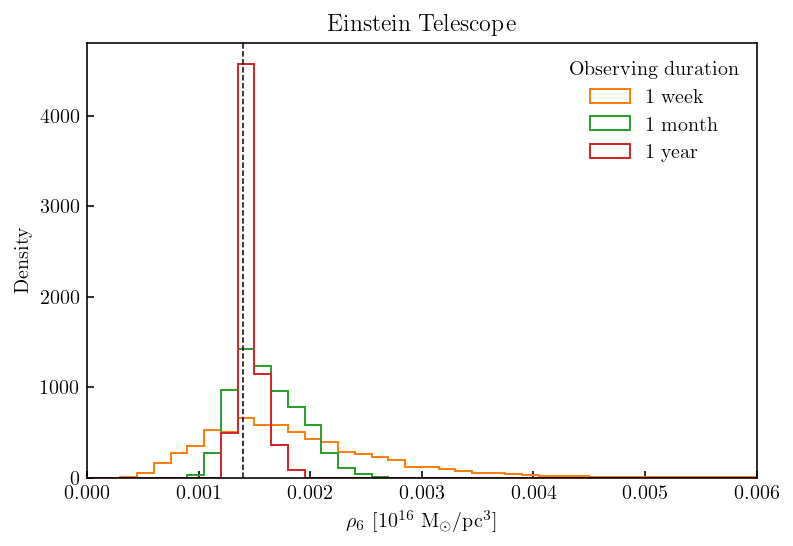

In [303]:
bins = np.linspace(0, 0.006, 41)
for i, (results, t_obs_label) in enumerate(
    zip(
        [results_et_1week, results_et_1month, results_et_1yr],
        ["1 week", "1 month", "1 year"],
    ),
    start=1,
):
    samples = (results["samples"] - offsets).T[1]
    ndim = samples.shape[0]
    weights = np.exp(results["logwt"] - results["logz"][-1])
    plt.hist(
        samples,
        bins,
        weights=weights,
        density=True,
        color=f"C{i}",
        histtype="step",
        label=t_obs_label,
    )

plt.axvline(DD_D.rho_6 / (1e16 * MSUN / PC ** 3), **TRUTH_KWARGS)
plt.xlim(bins[[0, -1]])
plt.xlabel(labels[1])
plt.ylabel("Density")
plt.legend(title="Observing duration")
plt.title("Einstein Telescope")
plt.savefig("../figures/post-rho6-et-week-month-year-4d.pdf")

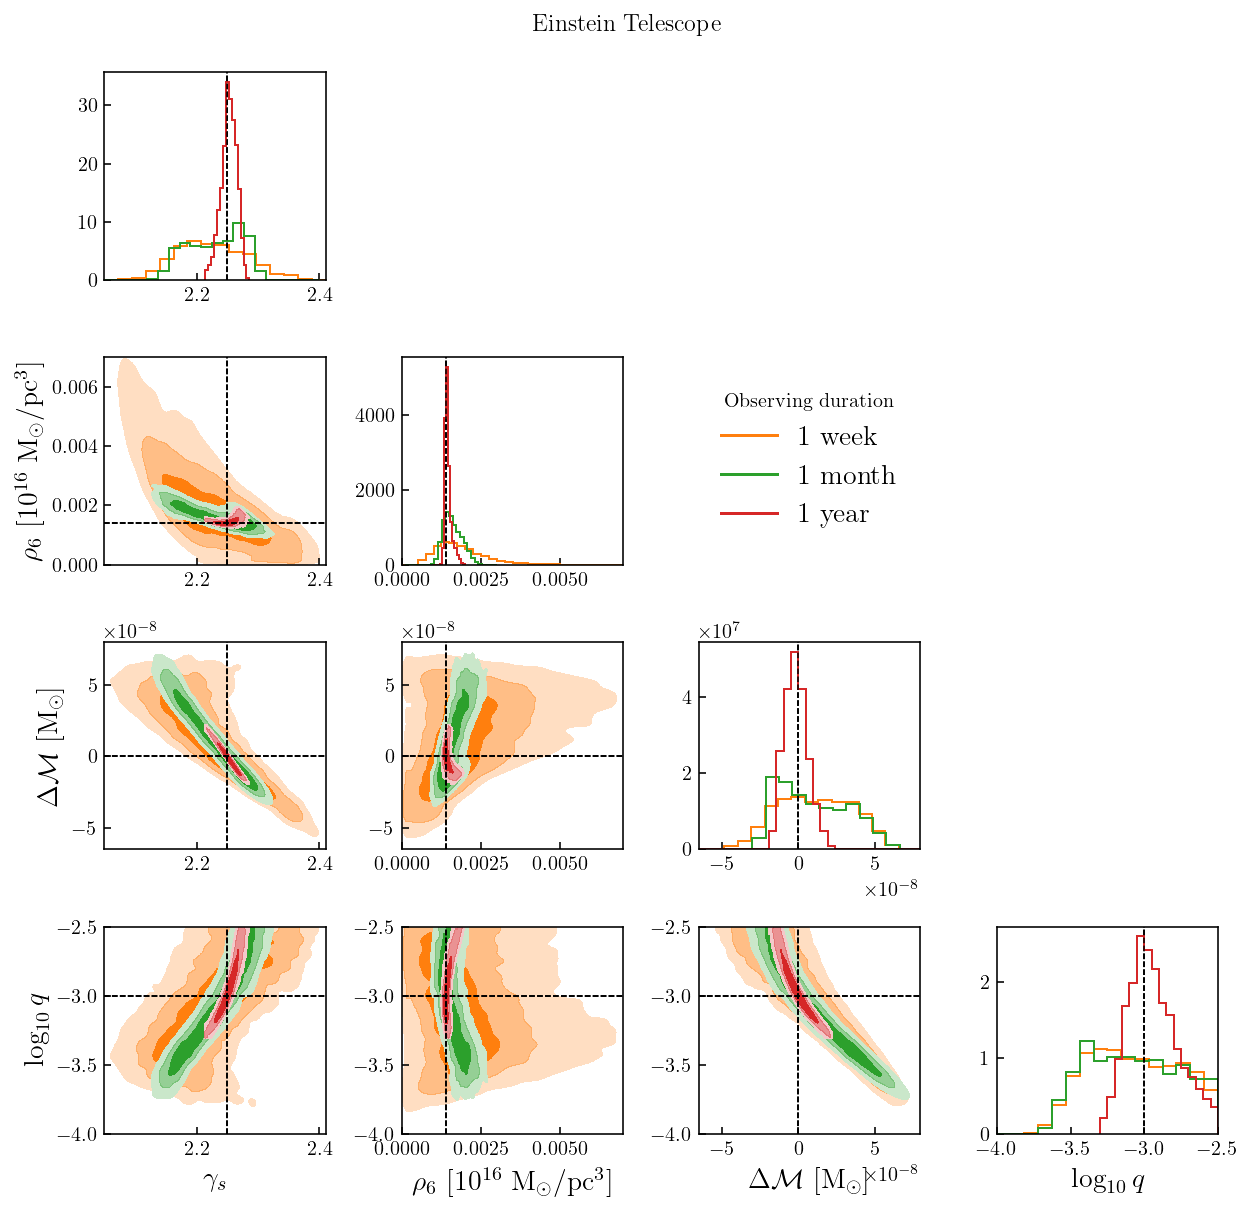

In [304]:
ndim = 4
fig, axes = plt.subplots(ndim, ndim, figsize=(2.2 * ndim, 2.2 * ndim))

offsets = (0, 0, DD_D.M_chirp / MSUN, 0)

my_corner(
    results_et_1week,
    axes,
    truths,
    "C1",
    smooth=0.018,
    bins_1d=(20, 80, 250, 16),
    offsets=offsets,
    contour_kwargs=dict(linewidths=0),
)
my_corner(
    results_et_1month,
    axes,
    truths,
    "C2",
    smooth=0.018,
    bins_1d=(20, 25, 250, 16),
    offsets=offsets,
    contour_kwargs=dict(linewidths=0),
)
my_corner(
    results_et_1yr,
    axes,
    truths,
    "C3",
    smooth=0.018,
    bins_1d=(15, 15, 40, 16),
    offsets=offsets,
    contour_kwargs=dict(linewidths=0),
)

for i, ax in enumerate(axes[-1, :]):
    ax.set_xlabel(labels[i], fontsize=14)

for j, ax in enumerate(axes[1:, 0], 1):
    ax.set_ylabel(labels[j], fontsize=14)

# Week/month/year
ranges = [
    (2.05, 2.41),
    (0.0, 0.007),
    (-6.5e-8, 8e-8),
    (-4, -2.5),
]
for i in range(ndim):
    for j in range(i, ndim):
        axes[j, i].set_xlim(ranges[i])

for i in range(1, ndim):
    for j in range(0, i):
        axes[i, j].set_ylim(ranges[i])

ax = axes[1, 2]
handles = ax.get_legend_handles_labels()[0]
for i, t_obs_label in enumerate(["1 week", "1 month", "1 year"], 1):
    line = Line2D([0], [0], label=t_obs_label, color=f"C{i}")
    handles.extend([line])
legend = ax.legend(handles=handles, title="Observing duration", loc="center", fontsize=14)
# plt.setp(legend.get_title(), fontsize=14)

# for ax in axes.flatten():
#     ax.tick_params(axis='both', which='major', labelsize=14)
#     ax.tick_params(axis='both', which='minor', labelsize=14)

fig.suptitle("Einstein Telescope")
fig.tight_layout(rect=[0, 0.03, 1, 0.985])
fig.savefig("../figures/post-et-week-month-year-4d.pdf")

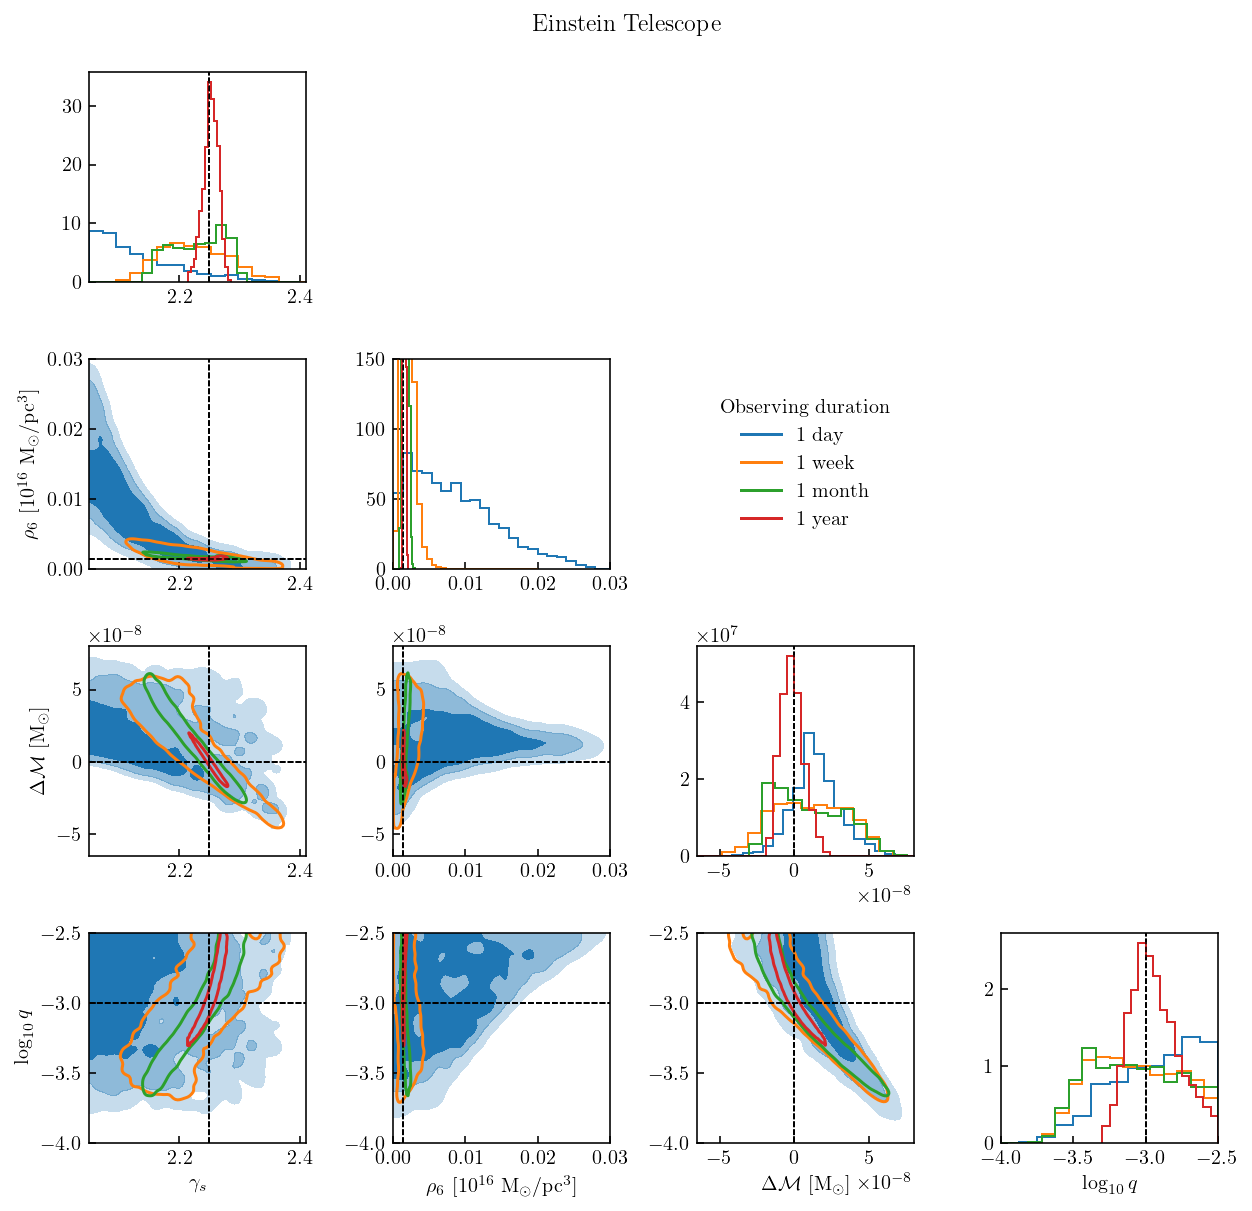

In [305]:
ndim = 4
fig, axes = plt.subplots(ndim, ndim, figsize=(2.2 * ndim, 2.2 * ndim))

offsets = (0, 0, DD_D.M_chirp / MSUN, 0)

my_corner(
    results_et_1day,
    axes,
    truths,
    "C0",
    smooth=0.025,
    bins_1d=(20, 30, 250, 16),
    offsets=offsets,
    contour_kwargs=dict(linewidths=0)
)
my_corner(
    results_et_1week,
    axes,
    truths,
    "C1",
    smooth=0.018,
    bins_1d=(20, 30, 250, 16),
    offsets=offsets,
    levels=(0, LEVELS[1]),
    no_fill_contours=True,
    contourf_kwargs=dict(alpha=0)
)
my_corner(
    results_et_1month,
    axes,
    truths,
    "C2",
    smooth=0.018,
    bins_1d=(20, 15, 250, 16),
    offsets=offsets,
    levels=(0, LEVELS[1]),
    no_fill_contours=True,
    contourf_kwargs=dict(alpha=0)
)
my_corner(
    results_et_1yr,
    axes,
    truths,
    "C3",
    smooth=0.018,
    bins_1d=(15, 15, 40, 16),
    offsets=offsets,
    levels=(0, LEVELS[1]),
    no_fill_contours=True,
    contourf_kwargs=dict(alpha=0)
)

for i, ax in enumerate(axes[-1, :]):
    ax.set_xlabel(labels[i])

for j, ax in enumerate(axes[1:, 0], 1):
    ax.set_ylabel(labels[j])

# Week/month/year
ranges = [
    (2.05, 2.41),
    (0.0, 0.03),
    (-6.5e-8, 8e-8),
    (-4, -2.5),
]
for i in range(ndim):
    for j in range(i, ndim):
        axes[j, i].set_xlim(ranges[i])

for i in range(1, ndim):
    for j in range(0, i):
        axes[i, j].set_ylim(ranges[i])

axes[1, 1].set_ylim(0, 150)

ax = axes[1, 2]
handles = ax.get_legend_handles_labels()[0]
for i, t_obs_label in enumerate(["1 day", "1 week", "1 month", "1 year"]):
    line = Line2D([0], [0], label=t_obs_label, color=f"C{i}")
    handles.extend([line])
ax.legend(handles=handles, title="Observing duration", loc="center")

fig.suptitle("Einstein Telescope")
fig.tight_layout(rect=[0, 0.03, 1, 0.985])
fig.savefig("../figures/post-et-all-4d.pdf")

## Discoverability

In [273]:
basedir = "../scripts/ns/vac/"
snr_thresh = 12
Mc_biases = {"ce": [], "et": []}
dNs = {"ce": [], "et": []}
snr_loss_fracs = {"ce": [], "et": []}
m1s = {"ce": [], "et": []}
m2s = {"ce": [], "et": []}
for fname in tqdm(os.listdir(basedir)):
    if os.path.splitext(fname)[1] != ".pkl":
        continue

    m1, m2 = (float(s.split("=")[1]) for s in itemgetter(1, 2)(fname.split("-")))
    with open(os.path.join(basedir, fname), "rb") as f:
        results = pickle.load(f)
    if "-et-" in fname:
        det = "et"
        S_n = S_n_et
        f_range = f_range_et
    elif "-ce-" in fname:
        det = "ce"
        S_n = S_n_ce
        f_range = f_range_ce

    # Get chirp mass bias, dephasing, SNR loss
    dd_s, f_range = get_target_pbh_dynamicdress(
        m1 * MSUN, m2 * MSUN, WEEK, snr_thresh, S_n, f_range
    )
    # Mc_map = results.samples[results.logz.argmax()].item()
    weights = jnp.exp(results.logwt - results.logz[-1])
    mean, cov = dyfunc.mean_and_cov(results.samples, weights)
    mean = mean.item()
    # std = jnp.sqrt(cov).item()
    Mc_biases[det].append((dd_s.M_chirp / MSUN - mean) / (dd_s.M_chirp / MSUN))

    vb = VacuumBinary(
        get_M_chirp(m1, m2) * MSUN, dd_s.Phi_c, dd_s.tT_c, dd_s.dL, dd_s.f_c
    )
    dNs[det].append((Phi_to_c(f_range[0], vb) - Phi_to_c(f_range[0], dd_s)) / (2 * pi))

    fs = jnp.linspace(*f_range, 100_000)
    pad_low, pad_high = get_match_pads(fs)
    match = calculate_match_unnormd_fft(dd_s, vb, fs, pad_low, pad_high, S_n)
    snr_loss_fracs[det].append((snr_thresh - jnp.sqrt(match)) / snr_thresh)

    m1s[det].append(m1)
    m2s[det].append(m2)

Mc_biases = {d: jnp.array(l) for d, l in Mc_biases.items()}
dNs = {d: jnp.array(l) for d, l in dNs.items()}
snr_loss_fracs = {d: jnp.array(l) for d, l in snr_loss_fracs.items()}
m1s = {d: jnp.array(l) for d, l in m1s.items()}
m2s = {d: jnp.array(l) for d, l in m2s.items()}

  0%|          | 0/401 [00:00<?, ?it/s]

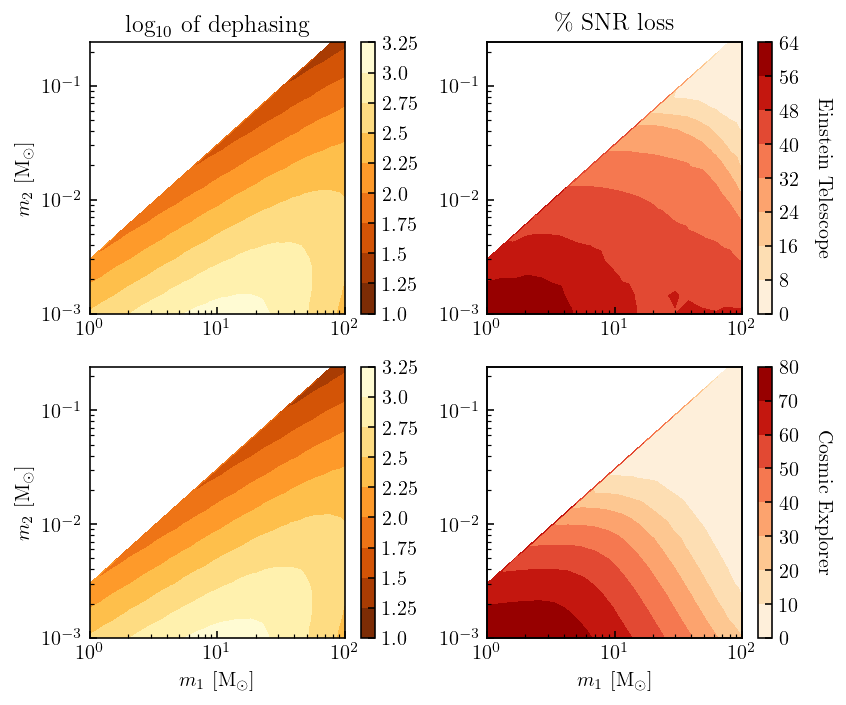

In [277]:
fig, axes = plt.subplots(2, 2, figsize=(3 * 2, 2.5 * 2))

for i, det, det_label in zip(
    range(2), ["et", "ce"], ["Einstein Telescope", "Cosmic Explorer"]
):
    ax = axes[i, 0]
    levels = np.linspace(1, 3.25, 10)
    cs = ax.tricontourf(
        m1s[det], m2s[det], jnp.log10(dNs[det]), levels=levels, cmap="YlOrBr_r"
    )
    cbar = plt.colorbar(cs, ax=ax)
    cbar.ax.set_yticklabels(levels)  # [r"$10^{%g}$" % l for l in levels])

    # ax = axes[0, 1]
    # cs = ax.tricontourf(m1s, m2s, Mc_biases, cmap="YlOrRd")
    # plt.colorbar(cs, ax=ax)
    # ax.set_title(r"$(\mathcal{M}_{\hat{\mathrm{V}}} - \mathcal{M}) / \Delta\mathcal{M}_{\hat{\mathrm{V}}}$")

    ax = axes[i, 1]
    cs = ax.tricontourf(m1s[det], m2s[det], snr_loss_fracs[det] * 100, cmap="OrRd")
    plt.colorbar(cs, ax=ax)

    ax.yaxis.tick_right()
    ax2 = ax.twinx()
    ax2.set_ylabel(det_label, labelpad=45, rotation=-90)
    ax2.set_yticks([])

axes[0, 0].set_title(r"$\log_{10}$ of dephasing")
axes[0, 1].set_title("\% SNR loss")

for ax in axes.flatten():
    ax.set_xscale("log")
    ax.set_yscale("log")

for ax in axes[-1, :]:
    ax.set_xlabel(r"$m_1$ [$\mathrm{M}_\odot$]")

for ax in axes[:, 0]:
    ax.set_ylabel(r"$m_2$ [$\mathrm{M}_\odot$]")

fig.tight_layout()
fig.savefig("../figures/discoverability-et-ce-week.pdf")